# Cluster DE (ignoring genes)

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot


fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [4]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [5]:
print(isoform.shape)
print(gene.shape)

(6160, 69172)
(6160, 19190)


In [6]:
gene = gene[gene.obs.subclass_label=="L6 CT"]
isoform = isoform[isoform.obs.subclass_label=="L6 CT"]

In [7]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
features = gene.var.gene_name.values
assignments   = gene.obs.cluster_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min

01-Nov-20 16:27:30 - 1 of 5 assignments: L6 CT Gpr139
01-Nov-20 16:27:30 - 2 of 5 assignments: L6 CT Grp_1
01-Nov-20 16:27:30 - 3 of 5 assignments: L6 CT Grp_2
01-Nov-20 16:27:30 - 4 of 5 assignments: L6 CT Nxph2_1
01-Nov-20 16:27:30 - 5 of 5 assignments: L6 CT Nxph2_2


CPU times: user 610 ms, sys: 363 ms, total: 974 ms
Wall time: 967 ms


In [8]:
%%time
mat         = isoform.layers["log1p"].todense() # expects dense matrix
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.cluster_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min

01-Nov-20 16:27:46 - 1 of 5 assignments: L6 CT Gpr139
01-Nov-20 16:27:46 - 2 of 5 assignments: L6 CT Grp_1
01-Nov-20 16:27:47 - 3 of 5 assignments: L6 CT Grp_2
01-Nov-20 16:27:47 - 4 of 5 assignments: L6 CT Nxph2_1
01-Nov-20 16:27:47 - 5 of 5 assignments: L6 CT Nxph2_2


CPU times: user 1.24 s, sys: 1.15 s, total: 2.4 s
Wall time: 2.39 s


# Look at isoform markers

In [9]:
alpha = 0.01
markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es").iloc[-10:-1]

,index,name,p_raw,p_corr,es
265292,L6 CT Nxph2_1,Cxcl12-202_ENSMUST00000112866,1.38912e-28,6.51082e-25,3.4853
42740,L6 CT Gpr139,Pcp4l1-201_ENSMUST00000111332,9.09351e-11,5.85986e-07,3.57437
59389,L6 CT Gpr139,Gpr139-201_ENSMUST00000084650,2.50324e-17,1.61309e-13,3.6476
47882,L6 CT Gpr139,Crtac1-201_ENSMUST00000048630,3.04375e-20,1.96139e-16,3.88047
17739,L6 CT Gpr139,Cidea-201_ENSMUST00000025404,3.99752e-26,2.576e-22,4.04082
59750,L6 CT Gpr139,Nnat-205_ENSMUST00000153739,4.60312e-10,2.96625e-06,4.22246
332278,L6 CT Nxph2_2,Glipr1-201_ENSMUST00000074805,8.06588e-07,0.00284564,4.47184
5413,L6 CT Gpr139,Acaa1b-201_ENSMUST00000010795,5.08234e-25,3.27506e-21,4.83885
285335,L6 CT Nxph2_2,Nts-201_ENSMUST00000020040,4.52533e-09,1.59654e-05,5.77943


In [14]:
specific_cluster = "L6 CT Gpr139"
specific_isoform = "Acaa1b-201_ENSMUST00000010795"
specific_gene = "".join(specific_isoform.split("-")[:-1])

In [15]:
gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

array(['Acaa1b_ENSMUSG00000010651'], dtype=object)

In [16]:
specific_gene = gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]

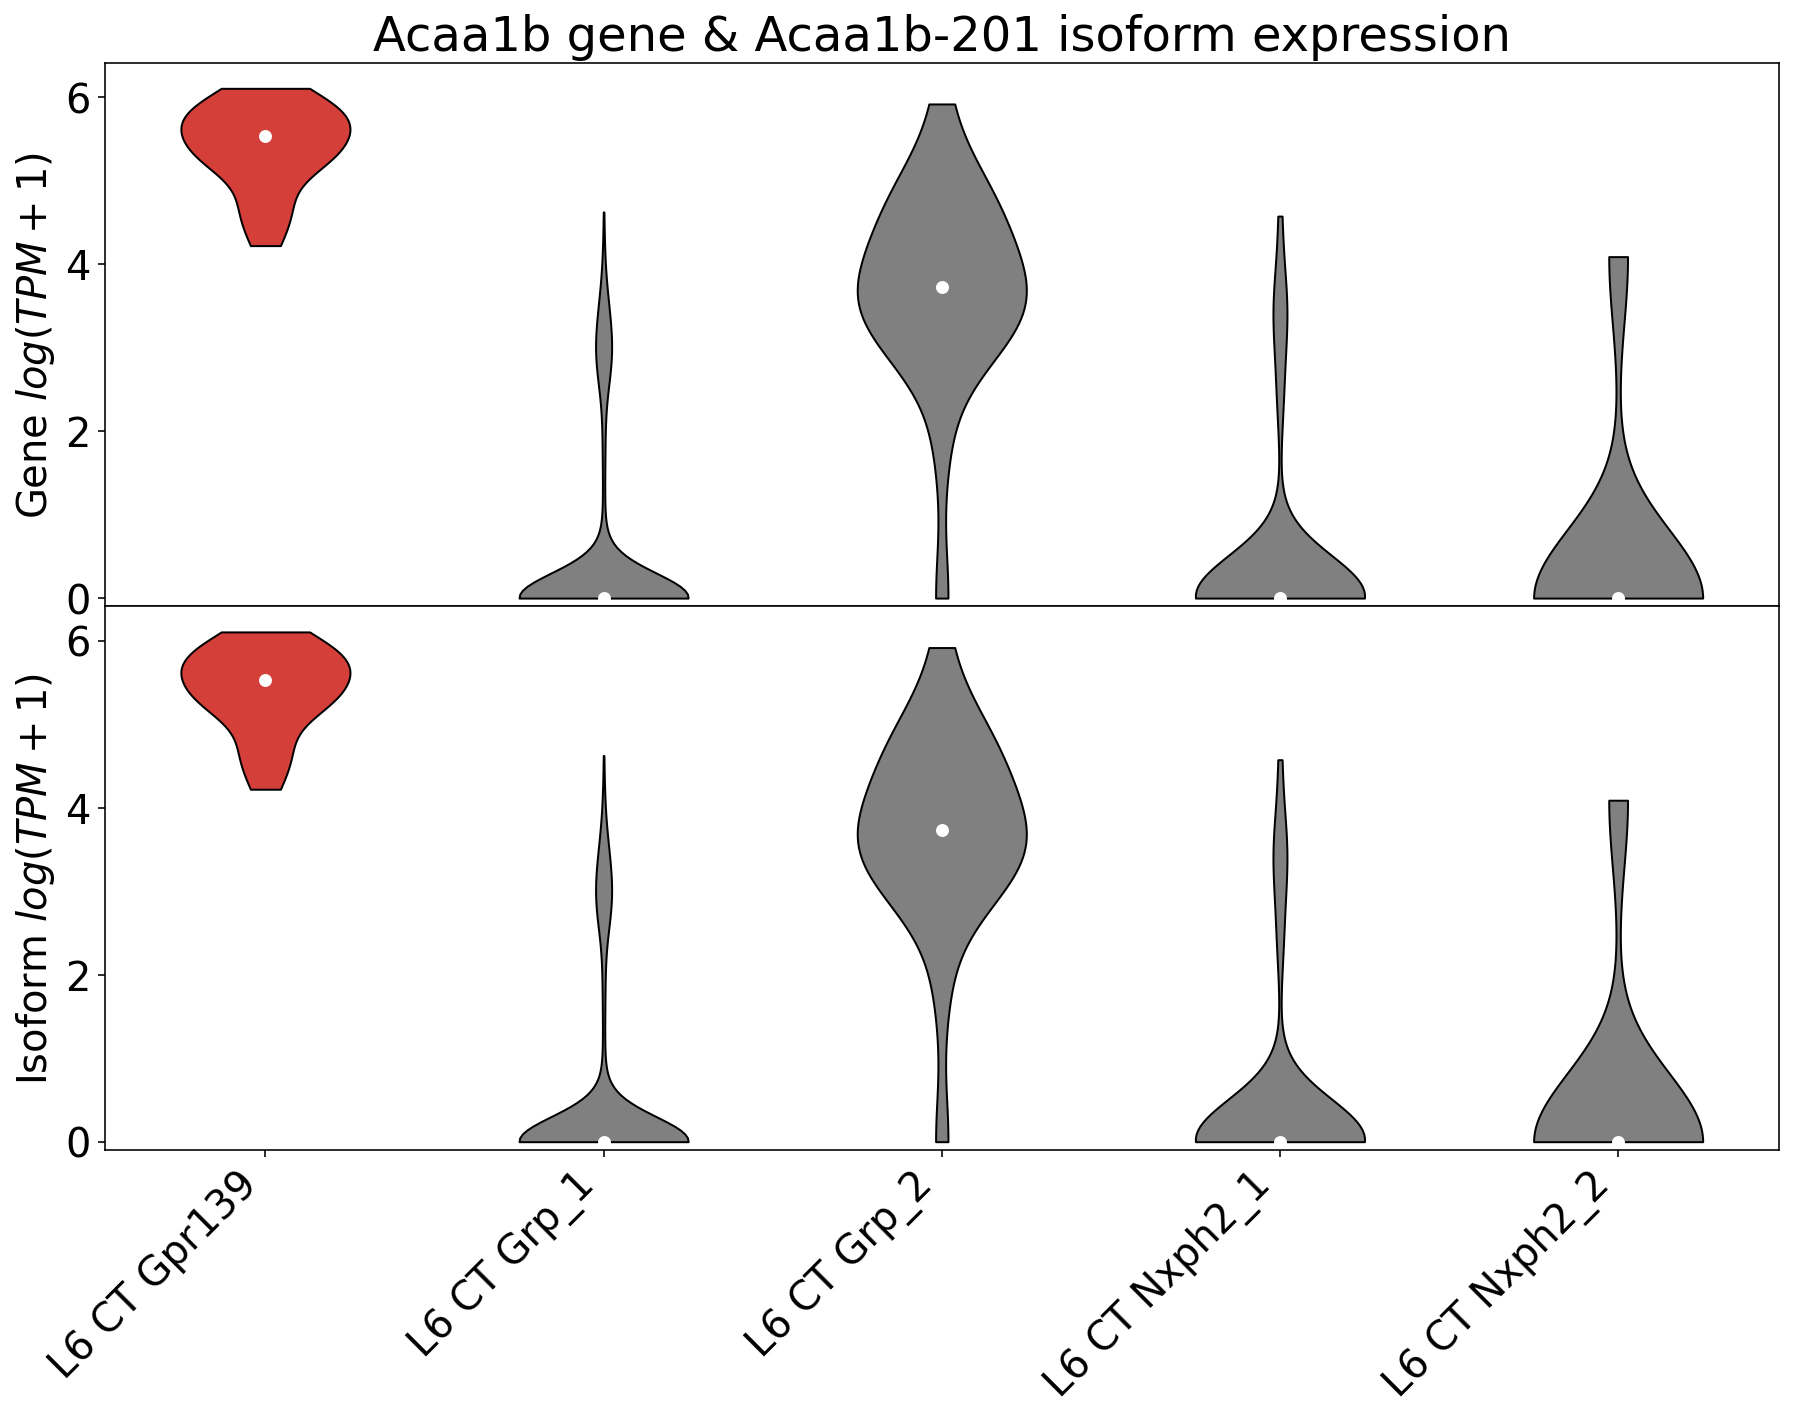

In [17]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene.obs.cluster_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.cluster_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[0].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax[0].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k")
ax[0].set_ylabel("Gene $log(TPM + 1)$")

######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.cluster_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[1].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

ax[0].set_ylim(-0.1)
medians = [np.median(i) for i in x]
ax[1].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)
ax[1].set_xticks(lidx)
ax[1].set_xticklabels(labels, rotation=45, ha="right")
ax[1].set_ylabel("Isoform $log(TPM + 1)$")
ymin, ymax = ax[0].get_ylim()
ax[1].set_ylim((ymin, ymax))
ax[0].set_title("{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]))
#plt.savefig("./figures/cluster_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [18]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from matplotlib import cm

In [19]:
num_NCA = 2
state = 42
num_PCA = 100

In [20]:
X = gene.X

tsvd = TruncatedSVD(n_components=num_PCA)
Y = tsvd.fit_transform(X)

In [21]:
# NCA
X = Y
y = gene.obs.cluster_id.values.astype(int)

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
YY = nca.fit_transform(X, y)

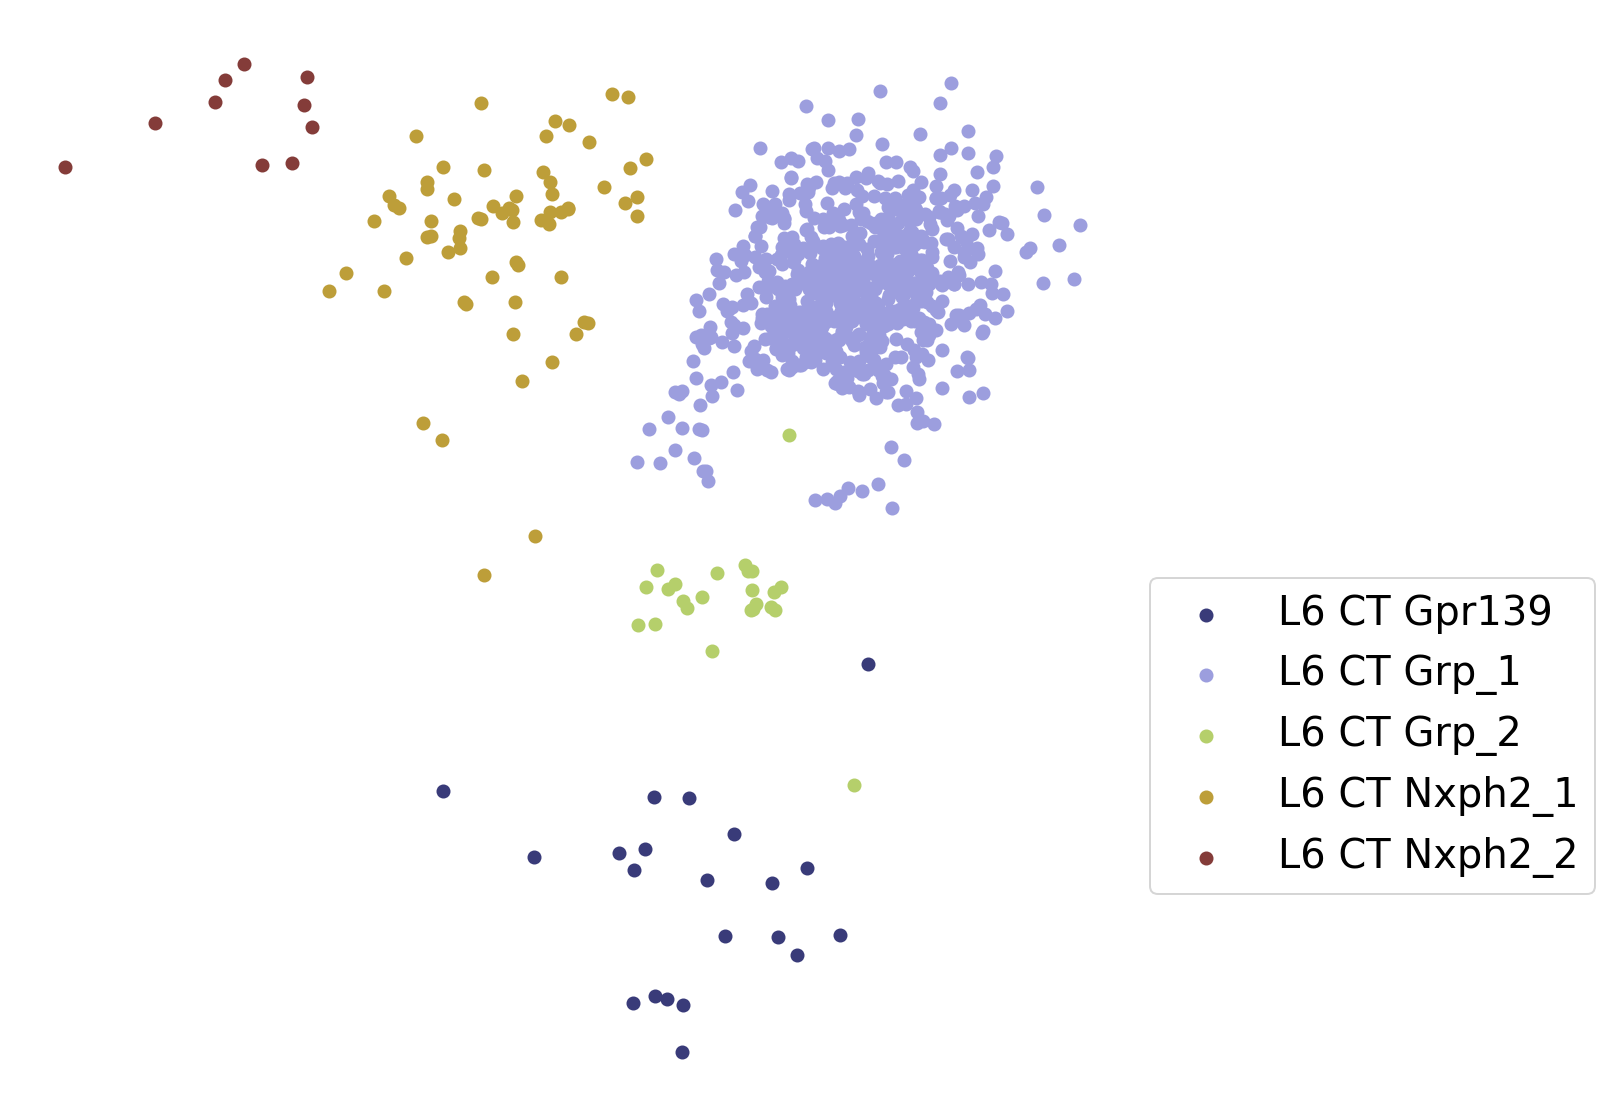

In [22]:
fig, ax = plt.subplots(figsize=(10,10))

x = YY[:,0]
y = YY[:,1]
c = cm.get_cmap("tab20b")
assignments = gene.obs.cluster_label.values
unique = np.unique(assignments)

for uidx, u in enumerate(unique):
    mask = assignments==u
    xx = x[mask]
    yy = y[mask]
    ax.scatter(xx, yy, color=c(uidx*3), cmap="tab20b", label=u)


ax.legend(bbox_to_anchor=(1, 0.5))

ax.set_axis_off()
plt.show()

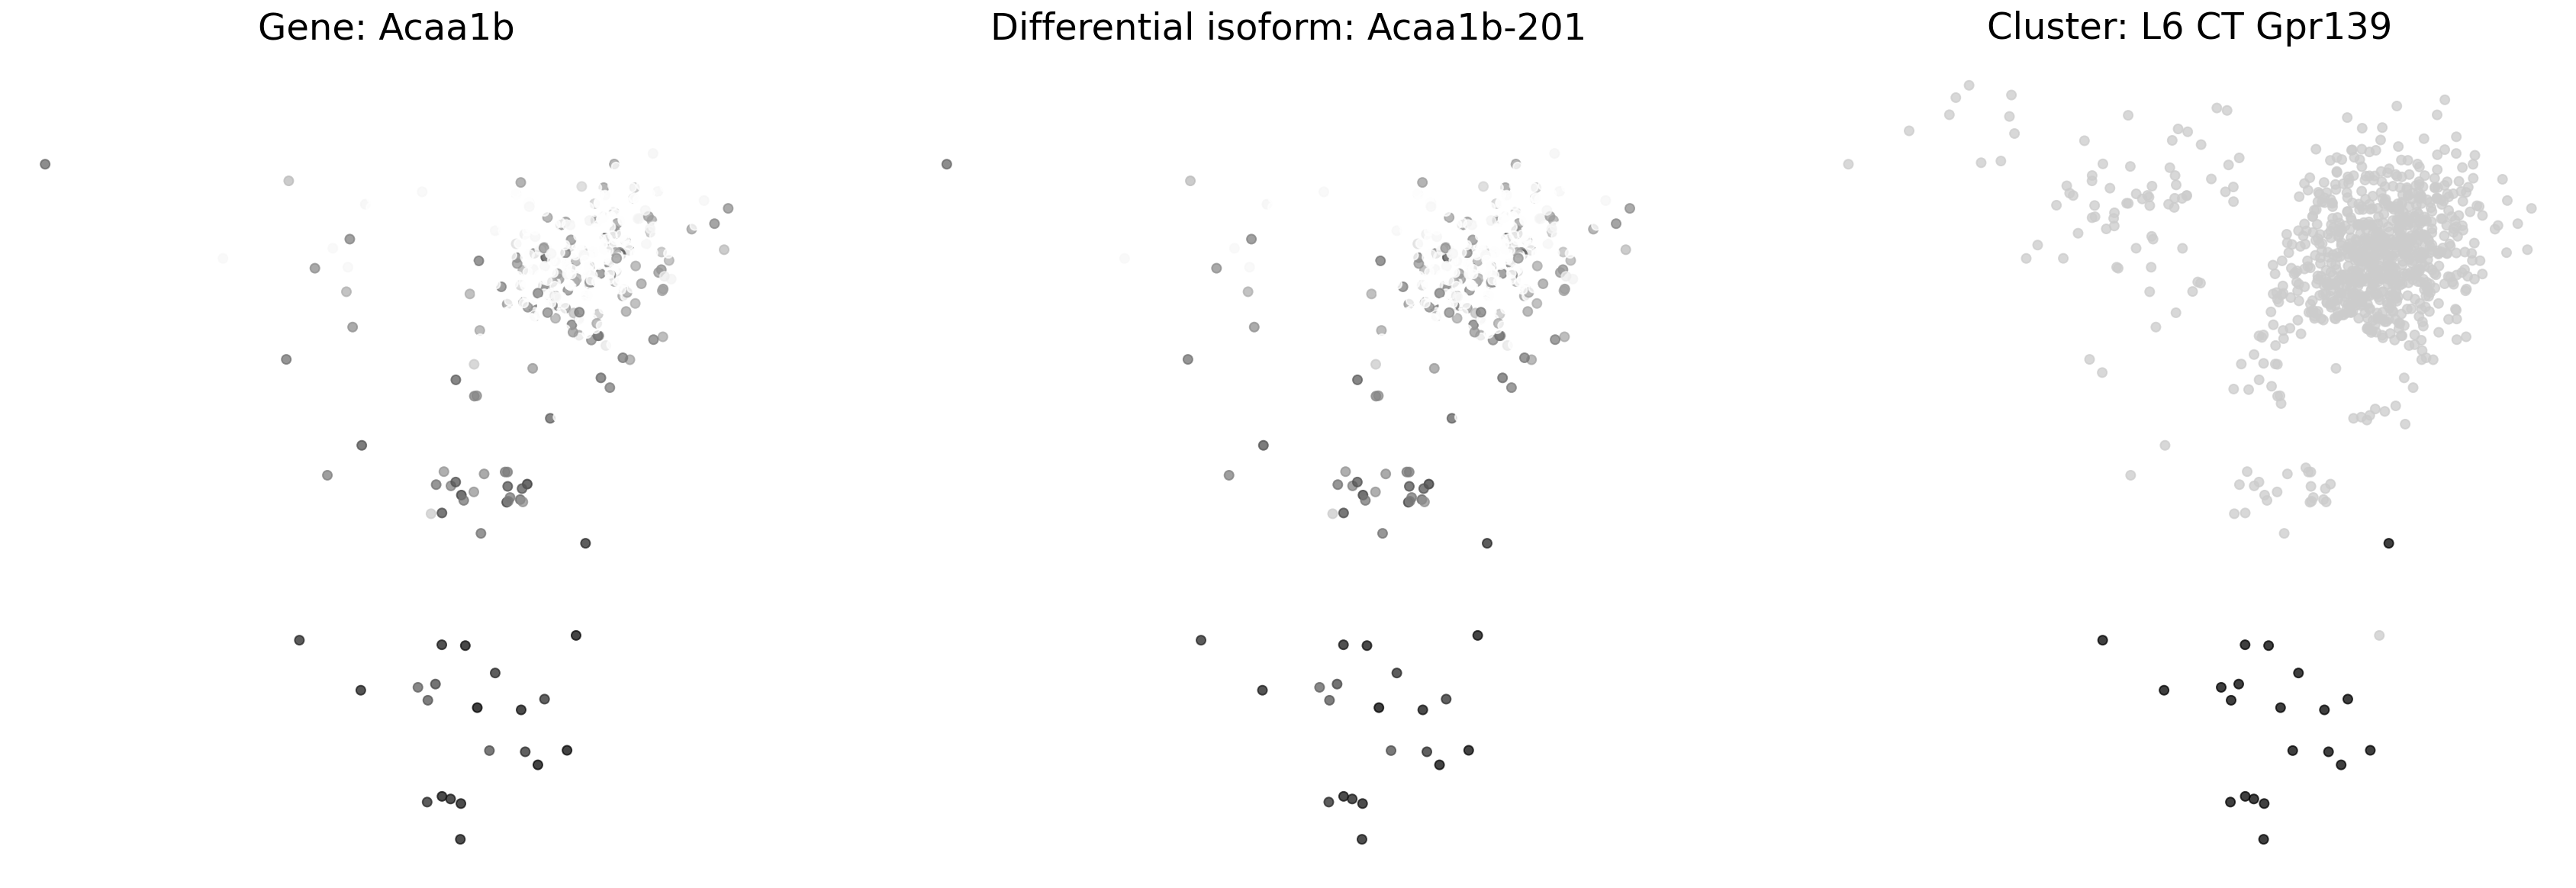

In [23]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = YY[:,0]
y = YY[:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = YY[:,0]
y = YY[:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = YY[:,0]
y = YY[:,1]

c = gene.obs["cluster_id"].values.astype(int)
c = gene.obs["cluster_label"]==specific_cluster

alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)

ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster))
#plt.savefig("./figures/cluster_DE_nca_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [24]:
identified_isoforms = markers_isoform["name"].explode().astype(str)
identified_isoforms = identified_isoforms[identified_isoforms!="nan"]

In [25]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [26]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

643 isoforms from 435 genes identified.


In [40]:
markers_isoform.to_csv("../../tables/unordered/cluster_DE_isoform_only.csv")